<a href="https://colab.research.google.com/github/cdmurray80/object_detection/blob/main/factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [2]:

#
# Helper functions
#
# Given covariance, compute correlation
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    return correlation
#Given covariance and loadings, compute variance.
#Of course if loadings are differences from target, this will return tracking risk squared
def compute_variance(cov, loadings):
  return(np.matmul(loadings.transpose(),np.matmul(cov, loadings))[0,0])


In [3]:
# Create our covariance matrix
cov_diag_term = 0.9
cov = np.matrix([[2.0,cov_diag_term],[cov_diag_term,1.2]]);

# Show the correation and covariance
cor = correlation_from_covariance(cov)
print('Cov:\n', cov, '\nCorrelation:\n', cor)

Cov:
 [[2.  0.9]
 [0.9 1.2]] 
Correlation:
 [[1.        0.5809475]
 [0.5809475 1.       ]]


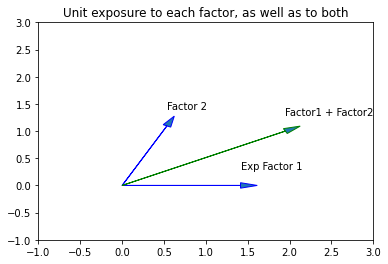

In [4]:
def arrow_w_title(plt_ax, x, y, title, edg_color='b'):
  plt_ax.arrow(0,0,x,y, head_length = 0.2, head_width=0.1, edgecolor=edg_color)
  plt_ax.annotate(title, xy=(x,y+0.3))
#
# Plot vectors to show risk of unit exposure to either factor
ax = plt.axes()
unit_var = compute_variance(cov, np.matrix([[1.],[1.]]))
arrow_w_title(ax, cov[0,0]**0.5,0, 'Exp Factor 1')

# This is a bit subtle...we use the covariance to determine where we'd land
# unit exposure to factor 2, such the the risk is the L2 norm of the factors
factor_2_dx = (unit_var - cov[1,1])**0.5 - cov[0,0]**0.5
arrow_w_title(ax, factor_2_dx,cov[1,1]**0.5, 'Factor 2')
arrow_w_title(ax, cov[0,0]**0.5 + factor_2_dx,1., 'Factor1 + Factor2', edg_color='g')
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
plt.title('Unit exposure to each factor, as well as to both')
plt.show()

In [5]:
# Sanity check that the variance of unit exposure to each factor equals the plotted L2 norm
print('Risk: {:.5f}, L2 Norm: {:.5f}'.format( unit_var ** 0.5, ((cov[0,0]**0.5 + factor_2_dx)**2 + cov[1,1])** 0.5))

Risk: 2.23607, L2 Norm: 2.23607


Eigenvalue  0 : 2.5848857801796106  and vector:
 [[0.83849224]
 [0.54491354]]
Eigenvalue  1 : 0.6151142198203895  and vector:
 [[-0.54491354]
 [ 0.83849224]]


<ipython-input-6-453f399e3f83>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


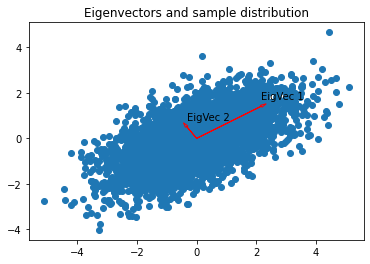

In [6]:
#Do eigen decomposition...annoying but we need code to sort eigenvectors so it's more than 1 line
eigenvalues, eigenvectors = np.linalg.eig(cov)
idx = (eigenvalues).argsort()[::-1]   
eigenvectors = eigenvectors[:,idx]
eigenvalues = eigenvalues[idx]

# Plot samples and eigenvectors
samples=np.random.multivariate_normal(np.array([0,0]),cov, size=4000)

plt.scatter(samples[:,0],samples[:,1])
ax=plt.axes()
for i in range(2):
  arrow_w_title(ax, eigenvectors[0,i]*eigenvalues[i],eigenvectors[1,i]*eigenvalues[i], 'EigVec ' + str(i+1), edg_color='r')
  print( 'Eigenvalue ', i, ':', eigenvalues[i], ' and vector:\n', eigenvectors[:,i])
plt.title('Eigenvectors and sample distribution')
plt.show()

[1. 1.] [[1.38340578 0.2935787 ]]


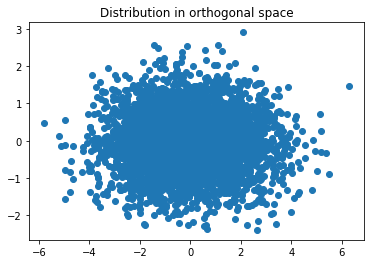

In [15]:
# Now the orthogonal factors are simply the eigenvectors times the raw factors...here I make up 'raw' factor loadings and compute 'orthogonalized' loadings
# Annoyingly you have to transpose the eigenvector matrix
#FIXME um, use the eigenvalues
raw_factor_loadings = np.array([1.,1.])
orthogonlized_factor_loadings = np.matmul(eigenvectors.transpose(), raw_factor_loadings)
print(raw_factor_loadings, orthogonlized_factor_loadings)
orthogonalized_samples = np.matmul(eigenvectors.transpose(), samples.transpose()).transpose()
# Use .A1 to get as an array
plt.scatter(orthogonalized_samples[:,0].A1,orthogonalized_samples[:,1].A1)
plt.title('Distribution in orthogonal space')
plt.show()